# Semantic Segmentation

**Segmentation** is one of the main computer vision task. For **each** pixel of image you must specify class(background included). Semantic segmentation only tells pixel class, instance segmentation divide classes into different instances. 

For instance segmentation ten cars is **different** objects, for semantic segmentation **all** cars is one class.

<img src="images/instance_vs_semantic.jpeg" width="50%">

> Image from [this blog post](https://nirmalamurali.medium.com/image-classification-vs-semantic-segmentation-vs-instance-segmentation-625c33a08d50)

Almost all architectures have same structure. First part is **encoder** that extracts features from input image, second part is **decoder** that transforms this features into image with same height and width and some number of channels, may be equal to classes count.

<img src="images/segm.png" width="80%">

> Image from [this publication](https://arxiv.org/pdf/2001.05566.pdf)

In [210]:
import tensorflow as tf
import tensorflow.keras.layers as keras
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import os
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.losses as losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)
np.random.seed(42)

In [211]:
train_size = 0.8
lr = 3e-4
weight_decay = 8e-9
batch_size = 64
epochs = 100

## Dataset

In [ ]:
!apt-get install rar
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
!unrar x -Y PH2Dataset.rar

In [198]:
def load_dataset(train_part, root='PH2Dataset'):
    images = []
    masks = []

    for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
        if root.endswith('_Dermoscopic_Image'):
            images.append(imread(os.path.join(root, files[0])))
        if root.endswith('_lesion'):
            masks.append(imread(os.path.join(root, files[0])))

    size = (256, 256)
    images = np.array([resize(image, size, mode='constant', anti_aliasing=True,) for image in images])
    masks = np.expand_dims(np.array([resize(mask, size, mode='constant', anti_aliasing=False) > 0.5 for mask in masks]), axis=3)

    indices = np.random.permutation(range(len(images)))
    train_part = int(train_part * len(images))
    train_ind = indices[:train_part]
    test_ind = indices[train_part:]

    X_train = tf.cast(images[train_ind, :, :, :], tf.float32)
    y_train = tf.cast(masks[train_ind, :, :, :], tf.float32)

    X_test = tf.cast(images[test_ind, :, :, :], tf.float32)
    y_test = tf.cast(masks[test_ind, :, :, :], tf.float32)

    return (X_train, y_train), (X_test, y_test)

In [199]:
(X_train, y_train), (X_test, y_test) = load_dataset(train_size)

In [200]:
def plotn(n, data):
    images, masks = data[0], data[1]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    for i, (img, mask) in enumerate(zip(images, masks)):
        if i == n:
            break
        ax[i].imshow(img)
        ax1[i].imshow(mask[:, :, 0])
    plt.show()

**Let's plot some images with corresponding masks.**

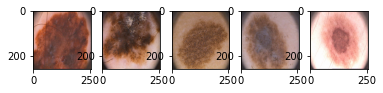

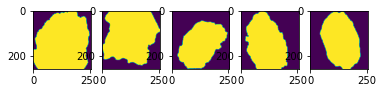

In [201]:
plotn(5, (X_train, y_train))

## SegNet

Simple encoder - decoder architecture with convolutions, poolings in encoder and convolutions, upsamplings in decoder.

<img src="images/segnet.png" width="80%">

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [212]:
class SegNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = keras.Conv2D(16, kernel_size=3, padding='same')
        self.bn0 = keras.BatchNormalization()
        self.relu0 = keras.Activation('relu')
        self.pool0 = keras.MaxPool2D()

        self.enc_conv1 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.relu1 = keras.Activation('relu')
        self.bn1 = keras.BatchNormalization()
        self.pool1 = keras.MaxPool2D()

        self.enc_conv2 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.relu2 = keras.Activation('relu')
        self.bn2 = keras.BatchNormalization()
        self.pool2 = keras.MaxPool2D()

        self.enc_conv3 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.relu3 = keras.Activation('relu')
        self.bn3 = keras.BatchNormalization()
        self.pool3 = keras.MaxPool2D()

        self.bottleneck_conv = keras.Conv2D(256, kernel_size=(3, 3), padding='same')

        self.upsample0 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv0 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.dec_relu0 = keras.Activation('relu')
        self.dec_bn0 = keras.BatchNormalization()

        self.upsample1 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv1 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.dec_relu1 = keras.Activation('relu')
        self.dec_bn1 = keras.BatchNormalization()

        self.upsample2 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv2 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.dec_relu2 = keras.Activation('relu')
        self.dec_bn2 = keras.BatchNormalization()

        self.upsample3 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv3 = keras.Conv2D(1, kernel_size=1)

    def call(self, input):
        e0 = self.pool0(self.relu0(self.bn0(self.enc_conv0(input))))
        e1 = self.pool1(self.relu1(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(self.relu2(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(self.relu3(self.bn3(self.enc_conv3(e2))))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_relu0(self.dec_bn0(self.upsample0(self.dec_conv0(b))))
        d1 = self.dec_relu1(self.dec_bn1(self.upsample1(self.dec_conv1(d0))))
        d2 = self.dec_relu2(self.dec_bn2(self.upsample2(self.dec_conv2(d1))))
        d3 = self.dec_conv3(self.upsample3(d2))

        return d3

In [213]:
model = SegNet()
optimizer = optimizers.Adam(learning_rate=lr, decay=weight_decay)
loss_fn = losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss_fn, optimizer=optimizer)

In [214]:
def train(datasets, model, epochs, batch_size):
    train_dataset, test_dataset = datasets[0], datasets[1]

    model.fit(train_dataset[0], train_dataset[1],
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(test_dataset[0], test_dataset[1]))

In [215]:
train(((X_train, y_train), (X_test, y_test)), model, epochs, batch_size)

Epoch 1/100
3/3 [==============================] - 2s 298ms/step - loss: 0.6123 - val_loss: 0.6960
Epoch 2/100
3/3 [==============================] - 1s 197ms/step - loss: 0.3332 - val_loss: 0.6874
Epoch 3/100
3/3 [==============================] - 1s 199ms/step - loss: 0.2715 - val_loss: 0.6707
Epoch 4/100
3/3 [==============================] - 1s 205ms/step - loss: 0.2508 - val_loss: 0.6544
Epoch 5/100
3/3 [==============================] - 1s 286ms/step - loss: 0.2290 - val_loss: 0.6403
Epoch 6/100
3/3 [==============================] - 1s 235ms/step - loss: 0.2110 - val_loss: 0.6242
Epoch 7/100
3/3 [==============================] - 1s 231ms/step - loss: 0.1986 - val_loss: 0.6138
Epoch 8/100
3/3 [==============================] - 1s 197ms/step - loss: 0.1923 - val_loss: 0.6068
Epoch 9/100
3/3 [==============================] - 1s 203ms/step - loss: 0.1789 - val_loss: 0.6018
Epoch 10/100
3/3 [==============================] - 1s 199ms/step - loss: 0.1714 - val_loss: 0.5979
Epoch 11/

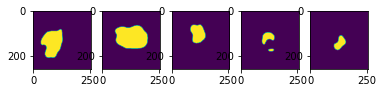

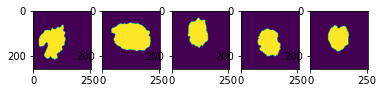

In [216]:
predictions = []
image_mask = []
plots = 5

for i, (img, mask) in enumerate(zip(X_test, y_test)):
    if i == plots:
        break
    img = tf.expand_dims(img, 0)
    pred = np.array(model.predict(img))
    predictions.append(pred[0, :, :, 0] > 0.5)
    image_mask.append(mask)
plotn(plots, (predictions, image_mask))

## U-Net

Very simple architecture that uses skip connections. Skip connections at each convolution level helps network doesn't lost information about features from original input at this level.

U-Net usually has a default encoder for feature extraction, for example resnet50.

<img src="images/unet.png" width="70%">

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. [U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)

In [217]:
class UNet(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = keras.Conv2D(16, kernel_size=3, padding='same')
        self.bn0 = keras.BatchNormalization()
        self.relu0 = keras.Activation('relu')
        self.pool0 = keras.MaxPool2D()

        self.enc_conv1 = keras.Conv2D(32, kernel_size=3, padding='same')
        self.relu1 = keras.Activation('relu')
        self.bn1 = keras.BatchNormalization()
        self.pool1 = keras.MaxPool2D()

        self.enc_conv2 = keras.Conv2D(64, kernel_size=3, padding='same')
        self.relu2 = keras.Activation('relu')
        self.bn2 = keras.BatchNormalization()
        self.pool2 = keras.MaxPool2D()

        self.enc_conv3 = keras.Conv2D(128, kernel_size=3, padding='same')
        self.relu3 = keras.Activation('relu')
        self.bn3 = keras.BatchNormalization()
        self.pool3 = keras.MaxPool2D()

        self.bottleneck_conv = keras.Conv2D(256, kernel_size=(3, 3), padding='same')

        self.upsample0 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv0 = keras.Conv2D(128, kernel_size=3, padding='same', input_shape=[None, 384, None, None])
        self.dec_relu0 = keras.Activation('relu')
        self.dec_bn0 = keras.BatchNormalization()

        self.upsample1 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv1 = keras.Conv2D(64, kernel_size=3, padding='same', input_shape=[None, 192, None, None])
        self.dec_relu1 = keras.Activation('relu')
        self.dec_bn1 = keras.BatchNormalization()

        self.upsample2 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv2 = keras.Conv2D(32, kernel_size=3, padding='same', input_shape=[None, 96, None, None])
        self.dec_relu2 = keras.Activation('relu')
        self.dec_bn2 = keras.BatchNormalization()

        self.upsample3 =  keras.UpSampling2D(interpolation='bilinear')
        self.dec_conv3 = keras.Conv2D(1, kernel_size=1, input_shape=[None, 48, None, None])

        self.cat0 = keras.Concatenate(axis=3)
        self.cat1 = keras.Concatenate(axis=3)
        self.cat2 = keras.Concatenate(axis=3)
        self.cat3 = keras.Concatenate(axis=3)

    def call(self, input):
        e0 = self.pool0(self.relu0(self.bn0(self.enc_conv0(input))))
        e1 = self.pool1(self.relu1(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(self.relu2(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(self.relu3(self.bn3(self.enc_conv3(e2))))

        cat0 = self.relu0(self.bn0(self.enc_conv0(input)))
        cat1 = self.relu1(self.bn1(self.enc_conv1(e0)))
        cat2 = self.relu2(self.bn2(self.enc_conv2(e1)))
        cat3 = self.relu3(self.bn3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        cat_tens0 = self.cat0([self.upsample0(b), cat3])
        d0 = self.dec_relu0(self.dec_bn0(self.dec_conv0(cat_tens0)))

        cat_tens1 = self.cat1([self.upsample1(d0), cat2])
        d1 = self.dec_relu1(self.dec_bn1(self.dec_conv1(cat_tens1)))

        cat_tens2 = self.cat2([self.upsample2(d1), cat1])
        d2 = self.dec_relu2(self.dec_bn2(self.dec_conv2(cat_tens2)))

        cat_tens3 = self.cat3([self.upsample3(d2), cat0])
        d3 = self.dec_conv3(cat_tens3)

        return d3

In [221]:
model = UNet()
optimizer = optimizers.Adam(learning_rate=lr, decay=weight_decay)
loss_fn = losses.BinaryCrossentropy(from_logits=True)

model.compile(loss=loss_fn, optimizer=optimizer)

In [222]:
train(((X_train, y_train), (X_test, y_test)), model, epochs, batch_size)

Epoch 1/100
3/3 [==============================] - 5s 482ms/step - loss: 0.5073 - val_loss: 0.6237
Epoch 2/100
3/3 [==============================] - 1s 368ms/step - loss: 0.3388 - val_loss: 0.6192
Epoch 3/100
3/3 [==============================] - 1s 363ms/step - loss: 0.2867 - val_loss: 0.6133
Epoch 4/100
3/3 [==============================] - 1s 367ms/step - loss: 0.2624 - val_loss: 0.6043
Epoch 5/100
3/3 [==============================] - 1s 365ms/step - loss: 0.2435 - val_loss: 0.5949
Epoch 6/100
3/3 [==============================] - 1s 364ms/step - loss: 0.2320 - val_loss: 0.5844
Epoch 7/100
3/3 [==============================] - 1s 369ms/step - loss: 0.2201 - val_loss: 0.5781
Epoch 8/100
3/3 [==============================] - 1s 362ms/step - loss: 0.2119 - val_loss: 0.5673
Epoch 9/100
3/3 [==============================] - 1s 367ms/step - loss: 0.2047 - val_loss: 0.5588
Epoch 10/100
3/3 [==============================] - 1s 360ms/step - loss: 0.1946 - val_loss: 0.5544
Epoch 11/

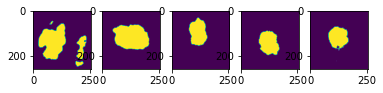

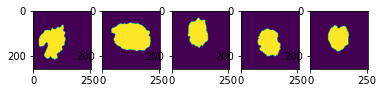

In [228]:
predictions = []
image_mask = []
plots = 5

for i, (img, mask) in enumerate(zip(X_test, y_test)):
    if i == plots:
        break
    img = tf.expand_dims(img, 0)
    pred = np.array(model.predict(img))
    predictions.append(pred[0, :, :, 0] > 0.5)
    image_mask.append(mask)
plotn(plots, (predictions, image_mask))